** Figure 4 - Regional fragment size distribution along the genome ** 

In order to count the number of short and long fragments in 100 kb bins, the script in the following cell was run on the mapped .bam files. Since their filesize is large and access is restricted due to legal reasons, we provide the output tables (GC corrected numbers of short and long fragments per bin) on our website, and we can continue working with them instead of the  .bam files. Therefore, you can skip the next cell and continue below.

In [ ]:
#### SKIP THIS CELL - REQUIRES .BAM FILES ###

import deeptools.countReadsPerBin as crpb
import glob
import deeptools
import matplotlib.pyplot as plt
import numpy as np
import py2bit
import pandas as pd
from loess.loess_1d import loess_1d
import statsmodels.api
import time
import sys

bamfiles=list(glob.glob(sys.argv[1]+"/*.bam"))

samplenames=[x.split("/")[-1].replace(".bam","") for x in bamfiles]
twobit="/home/peter/ctDNA/data/reference_data/hg38/hg38.2bit"
outdir="."
tb=py2bit.open(twobit)

for short_or_long in ["long","short"]:

    # Count reads per bin                                # 5mb for ML, 100kb otherwise
    cr = crpb.CountReadsPerBin(list(bamfiles), binLength=100000, stepSize=100000,
                               minMappingQuality=30,
                               ignoreDuplicates=False, # not nessesary since input file is already duplicate filtered 
                               numberOfProcessors=10, verbose=False,
                               genomeChunkSize=100000*100,
                               samFlag_exclude=256, # exclude if not primary alignment
                               extendReads=True,minFragmentLength=100 if short_or_long=="short" else 151,
                               maxFragmentLength=150 if short_or_long=="short" else 220,
                               out_file_for_raw_data=outdir+"/%s_rawdata_countreadsperbin.tsv"%(short_or_long),
                               blackListFileName="/home/peter/ctDNA/data/reference_data/hg38/blacklist/hg38.blacklist2.0_and_gaps.merged.bed")
    countobject=cr.run()

    # Get GC content for each bin
    gc_content_per_bin=[]
    with open(outdir+"/%s_rawdata_countreadsperbin.tsv"%(short_or_long)) as infile:
        for line in infile:
            chrom,start,end=line.split()[:3]
            start=int(start)
            end=int(end)
            try:
                gc_content_per_bin.append(deeptools.utilities.getGC_content(tb,chrom,start,end))
            except:
                gc_content_per_bin.append(np.nan)

    # store both in a dataframe
    df=pd.read_csv(outdir+"/%s_rawdata_countreadsperbin.tsv"%(short_or_long),delimiter="\t",header=None)
    df["GC"]=gc_content_per_bin
    df.columns=["chrom","start","end"]+samplenames+["GC"]
    df=df.assign(**{"mean_readcount_over_all_samples":df[samplenames].mean(axis="columns")})

    # filter out the 10% of bins with lowest read counts:
    # Note that this step was skipped for the 5mb bins used in the ML anaylsis
    df=df[df["mean_readcount_over_all_samples"]>df["mean_readcount_over_all_samples"].quantile(q=0.1)]

    # LOESS fitting and correction per sample
    df=df.sort_values(by="GC")
    for sample in samplenames:
        x=df["GC"].values
        y=df[sample].values

        yout=statsmodels.nonparametric.smoothers_lowess.lowess(endog=y,exog=x,frac=0.75,is_sorted=True,return_sorted=False)
        xout=x

        df=df.assign(**{sample+"_corrected":y-yout+np.median(y)})

        plt.clf()
        plt.plot(x, y, 'rx', label='Original data',alpha=0.1)
        plt.plot(xout, yout, 'b', linewidth=0.1, label='LOESS')
        plt.legend()
        plt.gcf().savefig(outdir+"/%s_%s_loess_before.pdf"%(short_or_long,sample))
        plt.close("all")

        plt.plot(df["GC"],df[sample+"_corrected"].values, 'rx', label='Corrected data',alpha=0.1)
        plt.plot(xout, yout, 'b', linewidth=0.1, label='LOESS')
        plt.legend()
        plt.gcf().savefig(outdir+"/%s_%s_loess_after.pdf"%(short_or_long,sample))
        plt.close("all")
        print("Finished sample %s"%(sample))

    df.to_csv(outdir+"/%s_readcounts_corr_and_uncorr_and_GC.csv"%(short_or_long))

    df=df.assign(**{"bin":df["chrom"]+"_"+df["start"].map(str)+"_"+df["end"].map(str)})
    df=df.sort_values(by=["chrom","start"])
    df_out=df[["bin"]+[x+"_corrected" for x in samplenames]]
    df_out.columns=["bin"]+samplenames
    df_out=df_out.set_index("bin")
    df_out=df_out.transpose()
    df_out.to_csv(outdir+"/%s_corr_readcounts.csv"%(short_or_long)) # these are the files we continue working with

Instead of running the above code, here we just download the output:

In [3]:
%%bash
wget http://medical-epigenomics.org/papers/peneder2020_f17c4e3befc643ffbb31e69f43630748/data/long_corr_readcounts.csv
wget http://medical-epigenomics.org/papers/peneder2020_f17c4e3befc643ffbb31e69f43630748/data/short_corr_readcounts.csv
wget http://medical-epigenomics.org/papers/peneder2020_f17c4e3befc643ffbb31e69f43630748/data/ichorCNA_output.tar.gz # CNA-information
tar -xzf ichorCNA_output.tar.gz

Note that ichorCNA (git commit 1d54a1f) was used to create the downloaded files as follows:

In [ ]:
%%bash

#### SKIP THIS CELL - REQUIRES .BAM FILES ###

### Readcounter
for((i=1;i<=${#BAMFILES[@]};i++));
do
    bamfile=${BAMFILES[i-1]}
    samplename=$(basename ${bamfile} $BAMFILE_SUFFIX)
    readCounter --window 500000 --quality 20 --chromosome \
    "chr1,chr2,chr3,chr4,chr5,chr6,chr7,chr8,chr9,chr10,chr11,chr12,chr13,chr14,chr15,chr16,chr17,chr18,chr19,chr20,chr21,chr22,chrX,chrY"\
    $bamfile > ${samplename}.readCounter_500kb_out.wig
done

### ichorCNA 
for((i=1;i<=${#BAMFILES[@]};i++));
do
    bamfile=${BAMFILES[i-1]}
    samplename=$(basename ${bamfile} $BAMFILE_SUFFIX)
    Rscript $ICHORCNA --id $samplename --WIG ${samplename}.readCounter_500kb_out.wig\
    --normal "c(0.5,0.6,0.7,0.8,0.9,0.95)" --ploidy "c(2,3)" --maxCN 5 \
    --gcWig ${ICHORCNA_BASEDIR}/inst/extdata/gc_hg38_500kb.wig \
    --mapWig ${ICHORCNA_BASEDIR}/inst/extdata/map_hg38_500kb.wig \
    --centromere ${ICHORCNA_BASEDIR}/inst/extdata/GRCh38.GCA_000001405.2_centromere_acen.txt \
    --includeHOMD False --chrs 'c(1:22,"X")' --chrTrain "c(1:22)" \
    --estimateNormal True --estimatePloidy True --estimateScPrevalence True \
    --scStates "c(1,3)" --txnE 0.9999 --txnStrength 10000 --outDir $(pwd) \
    --normal "c(0.5,0.6,0.7,0.8,0.9,0.95)" --genomeStyle=UCSC \
    --normalPanel ${ICHORCNA_BASEDIR}/inst/extdata/HD_ULP_PoN_hg38_500kb_median_normAutosome_median.rds 
done

Now we are ready to identify the bins which are significantly different to the controls, and determine the z-scores. We also use the output of ichorCNA to detect CNA-affected bins.
This script produces a number of output files per sample, which we can summarize, plot, and use as input for LOLA later on.

In [ ]:
import pandas as pd
import numpy as np
import math
import os
import scipy
from scipy import stats
from statsmodels.stats import multitest as mt
from matplotlib import pyplot as plt
import subprocess

def check_region_overlap(cn_event_region_list,cn_noevent_region_list,chrom,start,end):

    for regiontuple in cn_event_region_list:
        cv_chrom=regiontuple[0]
        cv_start=regiontuple[1]
        cv_end=regiontuple[2]
        if cv_chrom==chrom and ((cv_start<start and cv_end >start) or (cv_end>start and cv_start <end)):
            return True

    for regiontuple in cn_noevent_region_list:
        cv_chrom=regiontuple[0]
        cv_start=regiontuple[1]
        cv_end=regiontuple[2]
        if cv_chrom==chrom and ((cv_start<start and cv_end >start) or (cv_end>start and cv_start <end)):
            return False

    return np.nan

# create output dir
os.makedirs("significant_bins",exist_ok=True)

# Read in data
short_readcounts=pd.read_csv("short_corr_readcounts.csv")
long_readcounts=pd.read_csv("long_corr_readcounts.csv")

short_readcounts.columns=["sample"]+list(short_readcounts.columns[1:])
long_readcounts.columns=["sample"]+list(long_readcounts.columns[1:])

# Limit data to bins that are present both in the short and long read file
common_bins=[value for value in short_readcounts.columns if ((value in long_readcounts.columns) and ("chr" in value or "sample" in value) and ("random" not in value) and ("Un" not in value) )]

# Limit data to bins that have at least 100 short and long fragments in the controls:
short_df_NONnorm_cntrls=short_readcounts[(short_readcounts["sample"].str.contains("Ctrl"))]
short_df_NONnorm_cntrls=short_df_NONnorm_cntrls[short_readcounts.columns[1:]]
short_min=list(short_df_NONnorm_cntrls.min().values)
okay_bins_short=[binname for binname,minval  in zip(short_df_NONnorm_cntrls.columns,short_min) if minval>99]
long_df_NONnorm_cntrls=long_readcounts[(long_readcounts["sample"].str.contains("Ctrl"))]
long_df_NONnorm_cntrls=long_df_NONnorm_cntrls[long_readcounts.columns[1:]]
long_min=list(long_df_NONnorm_cntrls.min().values)
okay_bins_long=[binname for binname,minval  in zip(long_df_NONnorm_cntrls.columns,long_min) if minval>99]
common_bins=[x for x in common_bins if (x in okay_bins_long and x in okay_bins_short) or x=="sample"]
common_bins=[x for x in common_bins if not "chrY" in x]

print("Common bins:",len(common_bins))
print("Total bins:",short_readcounts.shape[1],",",long_readcounts.shape[1])
short_readcounts=short_readcounts[common_bins]
long_readcounts=long_readcounts[common_bins]

features=common_bins.copy()
features.remove("sample")

# Create column with the ratio short/long
short_long_df=short_readcounts[features].div(long_readcounts[features])
short_long_df["sample"]=short_readcounts["sample"]
short_long_df=short_long_df[["sample"]+features]
features.sort(key= lambda x: (25 if "X" in x else int(x.replace("chr","").split("_")[0]),int(x.split("_")[1]))) #sort by genomic position




for sample in short_long_df["sample"].values:
    import os
    if os.path.isfile("significant_bins/%s_vs_ctrls_pvals_etc_INCL_CNVaffected.json"%(sample,)):
        continue
    print("Treating sample %s"%(sample,))

    # Prepare df to get reference values from. Note that if the sample we are currently treating is a control, it is excluded from the references frame
    # then: nr_controls=21, else: nr_controls=22
    short_long_df_NONnorm_cntrls=short_long_df[(short_long_df["sample"].str.contains("Ctrl")) & (short_long_df["sample"]!=sample)] 
    nr_controls=len(short_long_df_NONnorm_cntrls["sample"].values)

    # Get tuples of regions, with the info if ichor marked the corresponding segment as CNV-affected
    ichor_segments=pd.read_csv("ichorCNA_output/ichorCNA_90to150_ss_all_samples/%s_90to150.seg"%(sample,),delimiter="\t")
    ichor_segments_nonneut=ichor_segments[ichor_segments["event"]!="NEUT"]
    ichor_segments_neut=ichor_segments[ichor_segments["event"]=="NEUT"]
    cn_event_region_list=[(chrom,int(start),int(end)) for (chrom,start,end) in zip(list(ichor_segments_nonneut["chr"].values),
                                                                                   list(ichor_segments_nonneut["start"].values),
                                                                                   list(ichor_segments_nonneut["end"].values))]
    cn_noevent_region_list=[(chrom,int(start),int(end)) for (chrom,start,end) in zip(list(ichor_segments["chr"].values),
                                                                                 list(ichor_segments["start"].values),
                                                                                 list(ichor_segments["end"].values))]

    # Prepare a dataframe that contains only allowed bins, and the information of this sample only
    df_onlyonesample=short_long_df[short_long_df["sample"]==sample]
    df_onlyonesample_shortreadcounts=short_readcounts[short_readcounts["sample"]==sample]
    df_onlyonesample_longreadcounts=long_readcounts[long_readcounts["sample"]==sample]
    # Filter out unwanted chromosomes
    common_bins=[value for value in df_onlyonesample_shortreadcounts.columns if ((value in df_onlyonesample_longreadcounts.columns) and ("chr" in value or "sample" in value) and ("random" not in value) and ("Un" not in value) )]
    df_onlyonesample=df_onlyonesample[common_bins]
    df_onlyonesample_shortreadcounts=df_onlyonesample_shortreadcounts[common_bins]
    df_onlyonesample_longreadcounts=df_onlyonesample_longreadcounts[common_bins]
    assert list(df_onlyonesample_longreadcounts.columns)==list(df_onlyonesample_shortreadcounts.columns)==list(df_onlyonesample.columns)

    df_onlyonesample=df_onlyonesample.set_index("sample").transpose()
    df_onlyonesample=df_onlyonesample.reset_index()
    df_onlyonesample.columns=["bin name","FC(short/long) - unnormalized"]

    df_onlyonesample_shortreadcounts=df_onlyonesample_shortreadcounts.set_index("sample").transpose()
    df_onlyonesample_shortreadcounts=df_onlyonesample_shortreadcounts.reset_index()
    df_onlyonesample_shortreadcounts.columns=["bin name","short"]

    df_onlyonesample_longreadcounts=df_onlyonesample_longreadcounts.set_index("sample").transpose()
    df_onlyonesample_longreadcounts=df_onlyonesample_longreadcounts.reset_index()
    df_onlyonesample_longreadcounts.columns=["bin name","long"]
    
    # Include info about position and CNA status 
    df_onlyonesample=df_onlyonesample.assign(**{"chromosome":[x.split("_")[0] for x in df_onlyonesample["bin name"].values],
                                                "start":[int(x.split("_")[1]) for x in df_onlyonesample["bin name"].values],
                                                "end":[int(x.split("_")[2]) for x in df_onlyonesample["bin name"].values],
                                                "gene":np.nan,
                                                "short":df_onlyonesample_shortreadcounts["short"],
                                                "long":df_onlyonesample_longreadcounts["long"],
                                                "weight":1})
    df_onlyonesample=df_onlyonesample.assign(**{"is_in_gain_or_loss_region":[check_region_overlap(cn_event_region_list,cn_noevent_region_list,chrom,start,end)
                                                                             for (chrom,start,end) in zip(list(df_onlyonesample["chromosome"].values),
                                                                                                          list(df_onlyonesample["start"].values),
                                                                                                          list(df_onlyonesample["end"].values))]})

    # kick out bins that have counts of short or long reads below 100:
    df_onlyonesample=df_onlyonesample[(df_onlyonesample["short"]>100) &(df_onlyonesample["long"]>100) ]

    # kick out all except chr 1-22:
    df_onlyonesample=df_onlyonesample[df_onlyonesample["chromosome"].isin(["chr"+str(x) for x in (range(1,23))])]

    # Normalize by genome wide mean - ignoring CNV-affected regions - to correct for overall fragment size distribution
    genomewide_mean_fc=df_onlyonesample[df_onlyonesample["is_in_gain_or_loss_region"]==False]["FC(short/long) - unnormalized"].mean()
    df_onlyonesample=df_onlyonesample.assign(**{"FC(short/long)":[x/genomewide_mean_fc for x in df_onlyonesample["FC(short/long) - unnormalized"]]})

    df_onlyonesample=df_onlyonesample.assign(**{"UNNORMALIZED log2":[np.log2(x) for x in df_onlyonesample["FC(short/long) - unnormalized"].values]})
    genomewide_mean_logfc=df_onlyonesample[df_onlyonesample["is_in_gain_or_loss_region"]==False]["UNNORMALIZED log2"].mean()
    df_onlyonesample=df_onlyonesample.assign(**{"log2":[x-genomewide_mean_logfc for x in df_onlyonesample["UNNORMALIZED log2"]]})

    # Normalize the controls by the genome wide mean, and use the same bins for mean-calculation as for the tumor sample
    short_to_long_per_ctrl=[[singlebinlist[control_idx] for singlebinlist in [short_long_df_NONnorm_cntrls[x].values for x in df_onlyonesample[df_onlyonesample["is_in_gain_or_loss_region"]==False]["bin name"].values]] for control_idx in range(nr_controls)]
    genome_wide_mean_per_ctrl_fc=[np.mean(x) for x in short_to_long_per_ctrl]
    genome_wide_mean_per_ctrl_logfc=[np.mean(np.log2(x)) for x in short_to_long_per_ctrl]
    df_onlyonesample=df_onlyonesample.assign(**{"reference log2":[np.log2(y)-genome_wide_mean_per_ctrl_logfc for y in [short_long_df_NONnorm_cntrls[x].values for x in df_onlyonesample["bin name"].values]]})
    df_onlyonesample=df_onlyonesample.assign(**{"reference FC":[y-genome_wide_mean_per_ctrl_fc for y in [short_long_df_NONnorm_cntrls[x].values for x in df_onlyonesample["bin name"].values]]})
    df_onlyonesample=df_onlyonesample.assign(**{"UNNORMALIZED reference log2":[np.log2(y) for y in [short_long_df_NONnorm_cntrls[x].values for x in df_onlyonesample["bin name"].values]]})

    # Calculate various ways of quantifying strength of change vs ctrl
    df_onlyonesample=df_onlyonesample.assign(**{"zscore vs reference":[(x-np.mean(ref))/np.std(ref) for x,ref in zip(df_onlyonesample["log2"].values,df_onlyonesample["reference log2"].values)]})
    df_onlyonesample=df_onlyonesample.assign(**{"pval vs reference":[stats.norm.sf(abs(x))*2 for x in df_onlyonesample["zscore vs reference"].values]})
    # Benjamini-hochenberg FDR
    fdr_corr=mt.multipletests(pvals=df_onlyonesample["pval vs reference"].values, alpha=0.05, method="fdr_bh")
    df_onlyonesample=df_onlyonesample.assign(**{"FDR vs reference":fdr_corr[1]})
    df_onlyonesample=df_onlyonesample.assign(**{"sum of reads":df_onlyonesample["short"]+df_onlyonesample["long"]})
    df_onlyonesample=df_onlyonesample.assign(**{"direction of change compared to reference":["longer frags than ref" if z<0 else "shorter frags than ref" for z in df_onlyonesample["zscore vs reference"]]})
    df_onlyonesample=df_onlyonesample.assign(**{"abs(log2)":[abs(x) for x in df_onlyonesample["log2"]]})
    df_onlyonesample=df_onlyonesample.assign(**{"FDR rank":df_onlyonesample["FDR vs reference"].rank(),
                                                "log2 rank":df_onlyonesample["abs(log2)"].rank(),
                                                "sum of reads rank":df_onlyonesample["sum of reads"].rank(ascending=False)})
    df_onlyonesample=df_onlyonesample.assign(**{"worst rank":[max([x,y,z]) for x,y,z in zip(df_onlyonesample["log2 rank"],
                                                                                           df_onlyonesample["sum of reads rank"],
                                                                                           df_onlyonesample["FDR rank"])]})
    df_onlyonesample=df_onlyonesample.assign(**{"sample":sample})
    df_onlyonesample=df_onlyonesample.sample(frac=1)
    df_onlyonesample=df_onlyonesample.sort_values(by="FDR vs reference")

    # Save the information we have gathered as JSON
    df_onlyonesample.to_json("significant_bins/%s_vs_ctrls_pvals_etc_INCL_CNVaffected.json"%(sample,))

    # Filter out regions that are affected by copy numbers, and regions that are not analyzed by ichorCNA
    df_onlyonesample=df_onlyonesample[df_onlyonesample["is_in_gain_or_loss_region"]==False]
    
    # this will be the LOLA universe:
    df_onlyonesample[["chromosome","start","end","sample","FDR vs reference"]].to_csv("significant_bins/%s_nonCNVaffected_bins.bed"%(sample,),sep="\t",header=False,index=False)

    df_onlyonesample_shorter=df_onlyonesample[df_onlyonesample["direction of change compared to reference"]=="shorter frags than ref"]
    df_onlyonesample_longer=df_onlyonesample[df_onlyonesample["direction of change compared to reference"]=="longer frags than ref"]
    
    # And these 2 sets will be the main LOLA input
    df_onlyonesample_shorter[df_onlyonesample_shorter["FDR vs reference"]<0.05][["chromosome","start","end","sample","FDR vs reference"]].to_csv("significant_bins/%s_significant_FDR_shorterfrag_bins.bed"%(sample,),sep="\t",header=False,index=False)
    df_onlyonesample_longer[df_onlyonesample_longer["FDR vs reference"]<0.05][["chromosome","start","end","sample","FDR vs reference"]].to_csv("significant_bins/%s_significant_FDR_longerfrag_bins.bed"%(sample,),sep="\t",header=False,index=False)
    
    # These 2 sets of random CNA neutral bins serve as controls
    df_onlyonesample[["chromosome","start","end","sample","FDR vs reference"]].sample(n=df_onlyonesample_shorter[df_onlyonesample_shorter["FDR vs reference"]<0.05].shape[0]).to_csv("significant_bins/%s_random_nonCNVaffected_bins_as_many_as_sign_shorter.bed"%(sample,),sep="\t",header=False,index=False)
    df_onlyonesample[["chromosome","start","end","sample","FDR vs reference"]].sample(n=df_onlyonesample_longer[df_onlyonesample_longer["FDR vs reference"]<0.05].shape[0]).to_csv("significant_bins/%s_random_nonCNVaffected_bins_as_many_as_sign_longer.bed"%(sample,),sep="\t",header=False,index=False)

Let's summarize the data we have collected so far:

In [ ]:
import pandas as pd
import glob
from scipy import stats

df_nr_total=pd.DataFrame()
df_nr_short=pd.DataFrame()
df_zscore_CNVnonaffected=pd.DataFrame()
df_log2_CNVnonaffected=pd.DataFrame()
df_zscore=pd.DataFrame()

for file in glob.glob("significant_bins/*vs_ctrls_pvals_etc_INCL_CNVaffected.json"):
    sample=file.split("/")[-1].replace("_vs_ctrls_pvals_etc_INCL_CNVaffected.json","")
    print("Summarizing", sample)
    sample_df=pd.read_json(file)
    sample_df_nr_total=sample_df[["bin name","sum of reads"]]
    sample_df_nr_short=sample_df[["bin name","short"]]
    sample_df_zscore=sample_df[~sample_df["is_in_gain_or_loss_region"].isna()][["bin name","zscore vs reference"]]
    sample_df_zscore_CNVnonaffected=sample_df[sample_df["is_in_gain_or_loss_region"]==False][["bin name","zscore vs reference"]]
    sample_df_log2_CNVnonaffected=sample_df[sample_df["is_in_gain_or_loss_region"]==False][["bin name","log2"]]
    sample_df=sample_df[["bin name","log2"]]

    sample_df_nr_total.columns=["bin name",sample]
    sample_df_nr_short.columns=["bin name",sample]
    sample_df_zscore.columns=["bin name",sample]
    sample_df_zscore_CNVnonaffected.columns=["bin name",sample]
    sample_df_log2_CNVnonaffected.columns=["bin name",sample]

    if df_nr_total.empty:
        df_nr_total=sample_df_nr_total
        df_nr_short=sample_df_nr_short
        df_zscore=sample_df_zscore
        df_zscore_CNVnonaffected=sample_df_zscore_CNVnonaffected
        df_log2_CNVnonaffected=sample_df_log2_CNVnonaffected

    else:
        df_nr_total=pd.merge(sample_df_nr_total,df_nr_total,left_on="bin name",right_on="bin name",how="inner")
        df_nr_short=pd.merge(sample_df_nr_short,df_nr_short,left_on="bin name",right_on="bin name",how="inner")
        df_zscore_CNVnonaffected=pd.merge(sample_df_zscore_CNVnonaffected,df_zscore_CNVnonaffected,left_on="bin name",right_on="bin name",how="outer")
        df_zscore=pd.merge(sample_df_zscore,df_zscore,left_on="bin name",right_on="bin name",how="outer")
        df_log2_CNVnonaffected=pd.merge(sample_df_log2_CNVnonaffected,df_log2_CNVnonaffected,left_on="bin name",right_on="bin name",how="outer")

df_nr_total=df_nr_total.set_index("bin name")
df_nr_total=df_nr_total.T
df_nr_total=df_nr_total.reset_index()
df_nr_total.columns=["sample"]+list(df_nr_total.columns)[1:]
df_nr_total.to_csv("Sumofreads_all_samples_all_bins.csv",index=False)
chroms=[x for x in df_nr_total.columns if "chr" in x]
df_nr_total_zscored=pd.DataFrame(stats.zscore(df_nr_total[chroms],axis=1))
df_nr_total_zscored.columns=df_nr_total[chroms].columns
df_nr_total_zscored=df_nr_total_zscored.assign(sample=df_nr_total["sample"])
df_nr_total_zscored.to_csv("Sumofreads_all_samples_all_bins_ZSCORED.csv",index=False) # this will be used in the ML part

df_nr_short=df_nr_short.set_index("bin name")
df_nr_short=df_nr_short.T
df_nr_short=df_nr_short.reset_index()
df_nr_short.columns=["sample"]+list(df_nr_short.columns)[1:]
df_nr_short.to_csv("Nr_short_reads_all_samples_all_bins.csv",index=False)
chroms=[x for x in df_nr_short.columns if "chr" in x]
df_nr_short_zscored=pd.DataFrame(stats.zscore(df_nr_short[chroms],axis=1))
df_nr_short_zscored.columns=df_nr_short[chroms].columns
df_nr_short_zscored=df_nr_short_zscored.assign(sample=df_nr_short["sample"])
df_nr_short_zscored.to_csv("Nr_short_reads_all_samples_all_bins_ZSCORED.csv",index=False) # this will be used in the ML part

df_zscore=df_zscore.set_index("bin name")
df_zscore=df_zscore.T
df_zscore=df_zscore.reset_index()
bins=list(df_zscore.columns)[1:]
df_zscore.columns=["sample"]+list(df_zscore.columns)[1:]
df_zscore.to_csv("zscore_all_samples.csv",index=False) # this will be used to generate the heatmap

df_zscore_CNVnonaffected=df_zscore_CNVnonaffected.set_index("bin name")
df_zscore_CNVnonaffected=df_zscore_CNVnonaffected.T
df_zscore_CNVnonaffected=df_zscore_CNVnonaffected.reset_index()
bins=list(df_zscore_CNVnonaffected.columns)[1:]
df_zscore_CNVnonaffected.columns=["sample"]+list(df_zscore_CNVnonaffected.columns)[1:]
df_zscore_CNVnonaffected.to_csv("zscore_CNVnonaffected_all_samples.csv",index=False) # this will be used in Fig 5 (Tumor evolution & progression)

df_log2_CNVnonaffected=df_log2_CNVnonaffected.set_index("bin name")
df_log2_CNVnonaffected=df_log2_CNVnonaffected.T
df_log2_CNVnonaffected=df_log2_CNVnonaffected.reset_index()
bins=list(df_log2_CNVnonaffected.columns)[1:]
df_log2_CNVnonaffected.columns=["sample"]+list(df_log2_CNVnonaffected.columns)[1:]
df_log2_CNVnonaffected.to_csv("log2_CNVnonaffected_all_samples.csv",index=False) # this will be used in Fig 5 (Tumor evolution & progression)

We can now visualize the zscored S/L ratio via a heatmap:

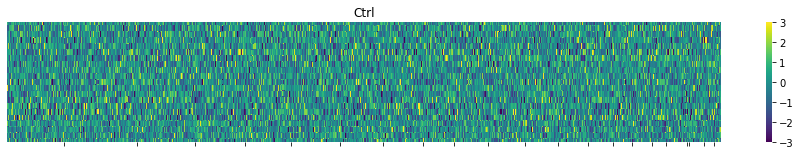

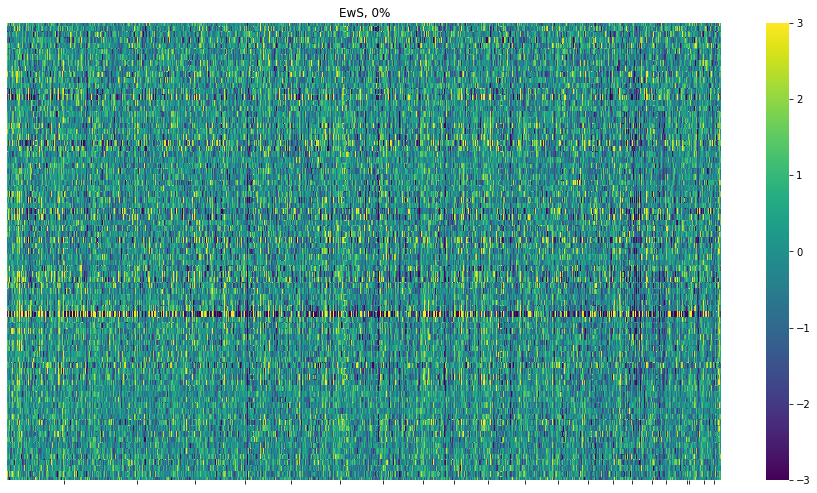

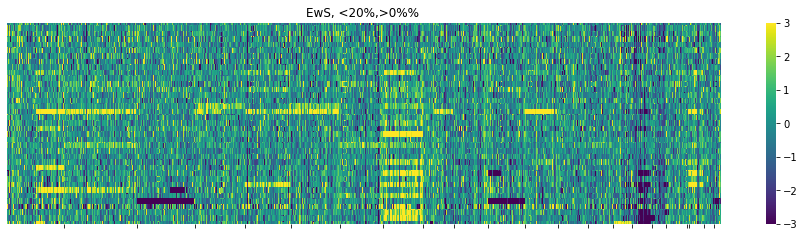

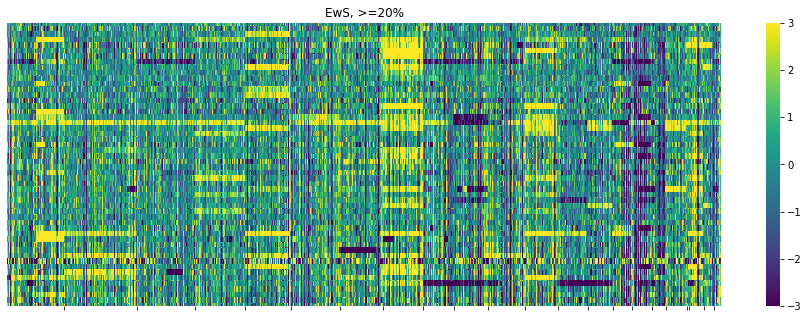

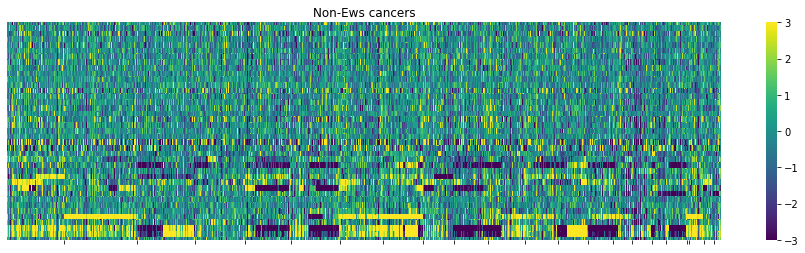

In [8]:
import glob
from matplotlib import pyplot as plt
import sys
import pandas as pd
import seaborn as sns
import matplotlib.patches as patches
import numpy as np

df=pd.read_csv("zscore_all_samples.csv",index_col="sample")

# Define the sample-sets:
clinical=pd.read_excel("../tables/Supplementary Table 1_Patient cohort.xlsx","Patient clinical data")
genomic=pd.read_excel("../tables/Supplementary Table 2_ctDNA quantification.xlsx","Genomic ctDNA quantification")
# note that in these two tables and the files other provided on this website, Rhabdomyosarcoma samples are encoded as "Rha" instead of "RMS"
non_ews_cancers=list(clinical[clinical["Sample type"]=="Non-EwS sarcoma"]["Sample"].values)
fixation_excluded_samples=list(genomic[genomic["Excluded due to fixation (1=yes)"]==1]["Sample"].values)
size_selected=list(genomic[genomic["Excluded due to size selection prior to library preparation (1=yes)"]==1]["Sample"].values)
controls=list(clinical[clinical["Sample type"]=="Healthy control"]["Sample"].values)

ews_samples_to_plot=genomic[~genomic["Sample"].isin(size_selected+fixation_excluded_samples+non_ews_cancers+controls)]
zero_perc=list(ews_samples_to_plot[ews_samples_to_plot["Combined quantification: % ctDNA"]==0]["Sample"].values)
upto20_perc=list(ews_samples_to_plot[(ews_samples_to_plot["Combined quantification: % ctDNA"]>0) & (ews_samples_to_plot["Combined quantification: % ctDNA"]<=20)]["Sample"].values)
morethan20_perc=list(ews_samples_to_plot[(ews_samples_to_plot["Combined quantification: % ctDNA"]>20)]["Sample"].values)
non_ews_cancers_to_plot=[x for x in non_ews_cancers if not x in size_selected+fixation_excluded_samples]

# Order the bins by their genomic location
bins=list(df.columns)
bins_s=[(int(x.split("_")[0].replace("chr","")),int(x.split("_")[1]),int(x.split("_")[2])) for x in bins]
# sort by chromosome, then by start
bins_s=sorted(bins_s,key=lambda x: x[1])
bins_s=sorted(bins_s,key=lambda x: x[0])
bins=["chr%s_%s_%s"%x for x in bins_s]
df=df[bins]
df.columns=["chr%s_%s"%(x[0],x[1]) for x in bins_s]

# Only consider bins for which we have data for every sample. This excludes e.g. bins for which ichorCNA gave no CNA status in one or more samples
df=df.dropna(axis=1)


chr_borders=[]
for chrom in range(1,23):
    for idx,bin in enumerate(df.columns):
        if "chr%s"%(chrom) in bin:
            chr_borders.append(idx)
            break

for sampleset,samplesetname in zip([controls,zero_perc,upto20_perc,morethan20_perc,non_ews_cancers_to_plot],["Ctrl","EwS, 0%","EwS, <20%,>0%% ","EwS, >=20%","Non-Ews cancers"]):

    # within each group, sort by tumor content
    samplesetdf=df.loc[sampleset]
    samplesetdf["Combined quantification: % ctDNA"]=samplesetdf.apply(lambda row: genomic[genomic["Sample"]==row.name]["Combined quantification: % ctDNA"].values[0],axis=1)
    samplesetdf=samplesetdf.sort_values(by="Combined quantification: % ctDNA")
    samplesetdf=samplesetdf.drop("Combined quantification: % ctDNA",axis=1)

    ax=sns.heatmap(samplesetdf,robust=True,cmap="viridis",vmin=-3,vmax=3,cbar=True,linewidths=0)
 
    # set size of plots according to the nr. of samples in the group
    plt.gcf().set_size_inches(16,len(sampleset)/10)
    
    plt.title(samplesetname)
    plt.xticks([],[])
    ax.set_xticks(chr_borders[1:])

    plt.yticks([],[])

    plt.ylabel("")
    plt.show()


Now, we use the bins with significantly shorter or longer fragments as input to LOLA. First, we need the LOLA core database:

In [17]:
%%bash
wget http://big.databio.org/regiondb/LOLACoreCaches_180412.tgz
tar -xzf LOLACoreCaches_180412.tgz
mkdir LOLAcore
mv nm LOLAcore

Please install R, and LOLA (v1.1) according to https://bioconductor.org/packages/release/bioc/html/LOLA.html 
Then, run the runLOLA.R file:

In [ ]:
%%bash
Rscript runLOLA.R

Finally, to plot the z-scored log2(S/L ratio) per chromosome arm and as well as bin-wise plots: 

Working on sample EwS_51_1
Working on sample EwS_52_1
Working on sample EwS_53_1
Working on sample EwS_54_1
Working on sample EwS_55_1
Working on sample EwS_59_1
Working on sample EwS_60_1
Working on sample EwS_57_1
Working on sample EwS_57_2
Working on sample EwS_57_3
Working on sample EwS_57_4
Working on sample EwS_57_5
Working on sample EwS_57_6
Working on sample EwS_57_7
Working on sample EwS_58_1
Working on sample EwS_58_2
Working on sample EwS_58_3
Working on sample EwS_58_4
Working on sample EwS_58_5
Working on sample EwS_58_6
Working on sample EwS_61_1
Working on sample EwS_62_1
Working on sample EwS_63_1
Working on sample EwS_63_2
Working on sample EwS_63_3
Working on sample EwS_63_4
Working on sample Ost_1_1
Working on sample Ost_1_2
Working on sample Ost_1_3
Working on sample EwS_1_1
Working on sample EwS_1_2
Working on sample EwS_1_3
Working on sample EwS_1_4
Working on sample EwS_1_5
Working on sample EwS_1_6
Working on sample EwS_1_7
Working on sample EwS_1_8
Working on s

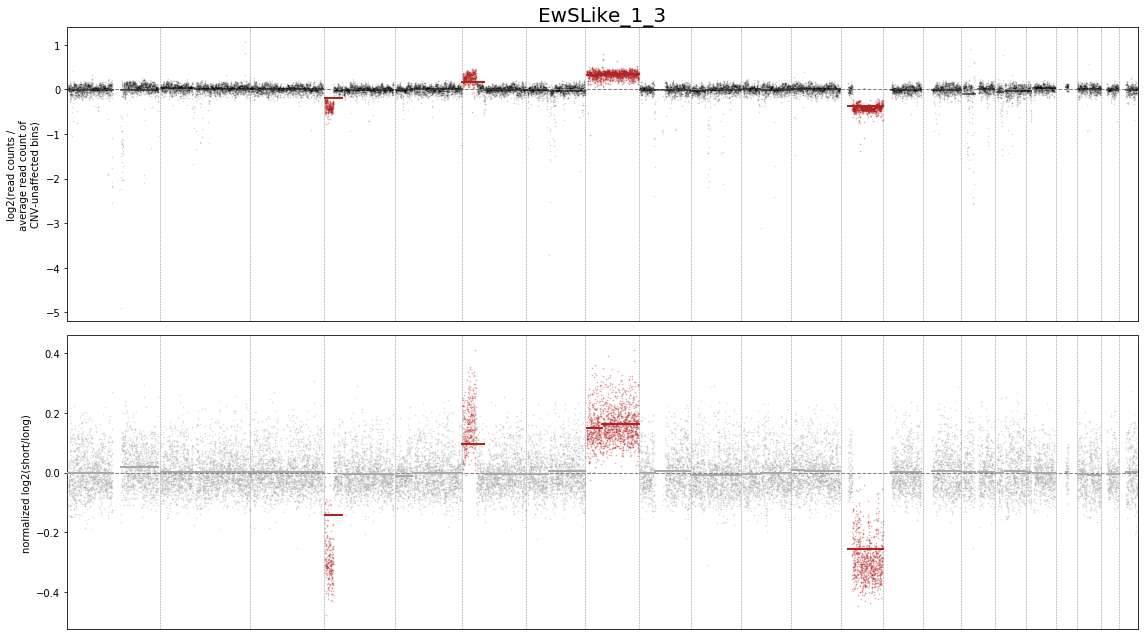

Working on sample EwS_48_1
Working on sample EwS_48_2
Working on sample EwS_48_3
Working on sample EwS_48_4
Working on sample EwS_67_1
Working on sample EwS_68_1
Working on sample EwS_69_1
Working on sample EwS_73_1
Working on sample EwS_70_1
Working on sample EwS_71_1
Working on sample EwS_4_1
Working on sample EwS_4_2
Working on sample EwS_4_3
Working on sample EwS_4_4
Working on sample EwS_5_1
Working on sample EwS_5_3
Working on sample EwS_5_2
Working on sample EwS_5_4
Working on sample EwS_5_5
Working on sample EwS_5_6
Working on sample EwS_72_1
Working on sample EwS_50_4
Working on sample EwS_50_1
Working on sample EwS_50_2
Working on sample EwS_50_3
Working on sample EwS_6_1
Working on sample EwS_6_3
Working on sample EwS_6_2
Working on sample EwS_6_4
Working on sample EwS_6_5
Working on sample EwS_6_6
Working on sample EwS_7_1
Working on sample EwS_7_2
Working on sample EwS_7_3
Working on sample EwS_7_7
Working on sample EwS_7_4
Working on sample EwS_7_5
Working on sample EwS_7

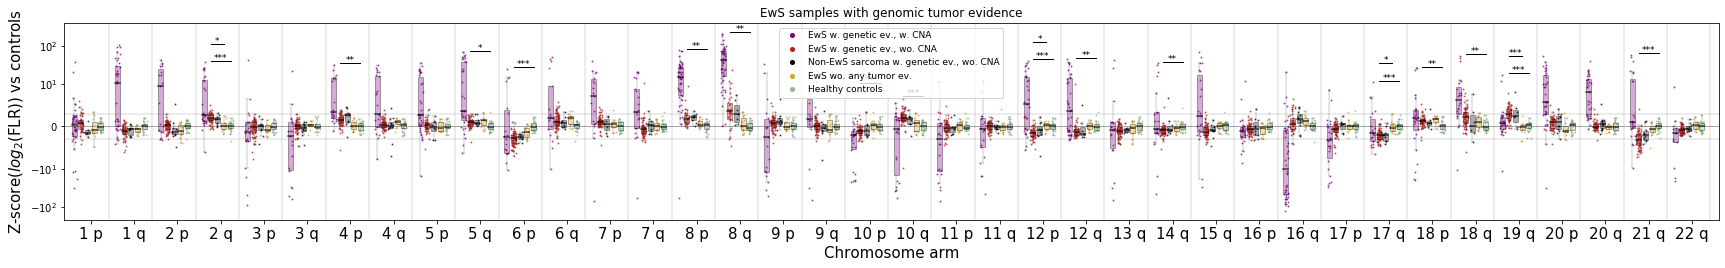

In [45]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pybedtools
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from collections import defaultdict
from scipy import stats
import seaborn as sns
import os
from scipy.stats import truncnorm
import matplotlib
from scipy import ndimage

## Helpful functions for plotting
def get_truncated_normal(mean=0., sd=1., low=0., upp=10.,size=1):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd).rvs(size=size)

def plot_violin_and_scatter(pos, color,color_scatter,data,cmap="not available",cmap_max=None):
    violin_parts=plt.gca().violinplot(data,positions=[pos],widths=0.3, showmedians=True,showextrema=False)
    if cmap=="not available":
        plt.plot(get_truncated_normal(mean=pos, sd=0.1,low=pos-0.15,upp=pos+0.15,size=len(data.values)),data,"x",color=color_scatter,markersize=0.5,zorder=10,alpha=0.5)
    else:
        cax=plt.scatter(get_truncated_normal(mean=pos, sd=0.1,low=pos-0.15,upp=pos+0.15,size=len(data.values)),data.values,marker="x",c=color_scatter,cmap=cmap,s=0.5,zorder=10,alpha=0.3)
        cax.cmap.set_over('pink',1.0)
        cax.set_clim(0,cmap_max) #https://stackoverflow.com/a/55966529/11808186
    for pc in violin_parts['bodies']:
        pc.set_facecolor(color)
        violin_parts['cmedians'].set_color('black')

def plot_scatter(pos, color_scatter,data,size=0.1,alpha=0.7,zorder=10):
    plt.plot(get_truncated_normal(mean=pos, sd=0.05,low=pos-0.10,upp=pos+0.10,size=len(data.values)),data,".",color=color_scatter,markersize=size,zorder=zorder,alpha=alpha)

def plot_violin(pos,color,data):
    violin_parts=plt.gca().violinplot(data,positions=[pos],widths=0.3, showmedians=True,showextrema=False)
    for pc in violin_parts['bodies']:
        pc.set_facecolor(color)
        violin_parts['cmedians'].set_color('black')

def plot_box(pos,color,data):
        plt.gca().boxplot(data,positions=[pos],widths=0.15, showfliers=False,
                          whiskerprops = dict(linestyle='-',linewidth=0.2, color='black'),
                          capprops = dict(linestyle='-',linewidth=0.2, color='black'),
                          boxprops=dict(facecolor=color,color="black",alpha=0.33),patch_artist=True,medianprops=dict(color="k",linewidth=1.5,alpha=0.7))
        plt.plot(get_truncated_normal(mean=pos, sd=0.05,low=pos-0.075,upp=pos+0.075,size=len(data.values)),data,".",color=color,markersize=2,zorder=0,alpha=0.6)

########### Paths and settings ###########

per_bin_fragratios_tables=list(glob.glob("significant_bins/*_vs_ctrls_pvals_etc_INCL_CNVaffected.json"))
cytobands="../tables/cytoBand.txt" #chromsome arm start and end positions for hg38; http://hgdownload.cse.ucsc.edu/goldenpath/hg38/database/cytoBand.txt.gz
esdhss=pybedtools.bedtool.BedTool("../tables/ews_specific_DHSs.bed")

plot_cnvs_and_log=True
plot_cnvs_and_log_selected_samples=["EwSLike_1_3"] # again, set to None for plotting all samples
plot_armwide_summary=True

# Define the sample-sets:
clinical=pd.read_excel("../tables/Supplementary Table 1_Patient cohort.xlsx","Patient clinical data")
genomic=pd.read_excel("../tables/Supplementary Table 2_ctDNA quantification.xlsx","Genomic ctDNA quantification")
# note that in these two tables and the files other provided on this website, Rhabdomyosarcoma samples are encoded as "Rha" instead of "RMS"
non_ews_cancers=list(clinical[clinical["Sample type"]=="Non-EwS sarcoma"]["Sample"].values)
fixation_excluded_samples=list(genomic[genomic["Excluded due to fixation (1=yes)"]==1]["Sample"].values)
size_selected=list(genomic[genomic["Excluded due to size selection prior to library preparation (1=yes)"]==1]["Sample"].values)
controls=list(clinical[clinical["Sample type"]=="Healthy control"]["Sample"].values)


########### Set a few basic variables for later on ###########

os.makedirs("plots",exist_ok=True)

# Get coordinates of p and q arms from cytobands file
arm_coords_dict=defaultdict(dict)
for mychrom in ["chr"+str(i) for i in range(1,23)]+["chrX"]:
    for arm in ["p","q"]:
        mymax=0
        mymin=np.inf
        arm_coords_dict[mychrom].update({arm:[mymin,mymax]})
        with open(cytobands) as infile:
            for line in infile:
                line=line.split()
                if line[0]==mychrom and line[3].startswith(arm):
                    if int(line[1]) < arm_coords_dict[mychrom][arm][0]:
                        arm_coords_dict[mychrom][arm][0]=int(line[1])
                    if int(line[2]) > arm_coords_dict[mychrom][arm][1]:
                        arm_coords_dict[mychrom][arm][1]=int(line[2])
                        
chromwide_zscore_of_each_sample_cnv_nan=defaultdict(list)
chromwide_zscore_of_each_sample_cnv_incl=defaultdict(list)
chromwide_log2_of_each_sample_cnv_incl=defaultdict(list)
chromwide_sumofreads_of_each_sample_cnv_incl=defaultdict(list)


########### For every sample: Plot ###########

for per_bin_fragratios_table in per_bin_fragratios_tables:

    sample=per_bin_fragratios_table.split("/")[-1].replace("_vs_ctrls_pvals_etc_INCL_CNVaffected.json","")
    print("Working on sample %s"%(sample))
    ratios_frame=pd.read_json(per_bin_fragratios_table)
    nr_controls=len(ratios_frame["reference log2"].values[0])

    if plot_armwide_summary:
        # this does not plot, but prepares the required dataframes for the arm-level summary plots
        for mychrom in list(range(1,23)):
            for arm in ["p","q"]:
                arm_start_coord=arm_coords_dict["chr"+str(mychrom)][arm][0]
                arm_end_coord=arm_coords_dict["chr"+str(mychrom)][arm][1]
                ratios_frame_this_chrom_arm=ratios_frame[(ratios_frame["chromosome"]=="chr"+str(mychrom)) & (ratios_frame["start"]>=arm_start_coord) & (ratios_frame["end"]<arm_end_coord)]
                if ratios_frame_this_chrom_arm[~ratios_frame_this_chrom_arm["is_in_gain_or_loss_region"].isna()].empty:
                    continue
                ratios_frame_this_chrom_arm=ratios_frame_this_chrom_arm.sort_values(by="start")

                log2s_ctrls_per_ctrl=[[singlebinlist[control_idx] for singlebinlist in ratios_frame_this_chrom_arm[~ratios_frame_this_chrom_arm["is_in_gain_or_loss_region"].isna()]["reference log2"].values] for control_idx in range(nr_controls)]
                means_per_ctrl=[np.mean(x) for x in log2s_ctrls_per_ctrl]
                std_over_all_ctrls=np.std([np.mean(x) for x in log2s_ctrls_per_ctrl])
                mean_over_all_ctrls=np.mean([np.mean(x) for x in log2s_ctrls_per_ctrl])
                zscore_vs_means_of_ctrls=(ratios_frame_this_chrom_arm[~ratios_frame_this_chrom_arm["is_in_gain_or_loss_region"].isna()]["log2"].mean()-mean_over_all_ctrls)/std_over_all_ctrls

                if ratios_frame_this_chrom_arm[ratios_frame_this_chrom_arm["is_in_gain_or_loss_region"]==True].empty:
                    chromwide_zscore_of_each_sample_cnv_nan["chr%s %s"%(mychrom,arm,)].append(zscore_vs_means_of_ctrls) #ratios_frame_this_chrom_arm[ratios_frame_this_chrom_arm["is_in_gain_or_loss_region"]==False]["zscore vs reference"].mean())
                else:
                    chromwide_zscore_of_each_sample_cnv_nan["chr%s %s"%(mychrom,arm,)].append(np.nan)

                chromwide_zscore_of_each_sample_cnv_incl["chr%s %s"%(mychrom,arm,)].append(zscore_vs_means_of_ctrls)
                chromwide_log2_of_each_sample_cnv_incl["chr%s %s"%(mychrom,arm,)].append(ratios_frame_this_chrom_arm[~ratios_frame_this_chrom_arm["is_in_gain_or_loss_region"].isna()]["log2"].mean())
                chromwide_sumofreads_of_each_sample_cnv_incl["chr%s %s"%(mychrom,arm,)].append(ratios_frame_this_chrom_arm[~ratios_frame_this_chrom_arm["is_in_gain_or_loss_region"].isna()]["sum of reads"].mean())
        chromwide_zscore_of_each_sample_cnv_nan["sample"].append(sample)
        chromwide_zscore_of_each_sample_cnv_incl["sample"].append(sample)
        chromwide_log2_of_each_sample_cnv_incl["sample"].append(sample)
        chromwide_sumofreads_of_each_sample_cnv_incl["sample"].append(sample)
                
                
    if plot_cnvs_and_log:
        if plot_cnvs_and_log_selected_samples==None or sample in plot_cnvs_and_log_selected_samples:  
            ax1=plt.subplot(3,1,1)

            ### First part: Plot CNAs
            plt.subplot(2,1,1,sharex=ax1)
            ratios_frame=ratios_frame.assign(**{"total_reads_per_bin":ratios_frame["short"] + ratios_frame["long"]})
            average_CNV_unaffacted=ratios_frame[ratios_frame["is_in_gain_or_loss_region"]==False]["total_reads_per_bin"].mean()
            ratios_frame=ratios_frame.assign(**{"log2_total_readcounts":[np.log2(x/average_CNV_unaffacted) for x in ratios_frame["total_reads_per_bin"].values]})
            ratios_frame=ratios_frame.assign(**{"center":[np.mean([x,y]) for x,y in zip(ratios_frame["start"].values,ratios_frame["end"].values)]})

            genomepos=0
            xlabelpositions=[]
            xlabels=[]
            for mychrom in list(range(1,23)):

                ratios_frame_this_chrom=ratios_frame[ratios_frame["chromosome"]=="chr"+str(mychrom)]
                ratios_frame_this_chrom=ratios_frame_this_chrom.sort_values(by="start")

                plt.scatter([x + genomepos for x in ratios_frame_this_chrom[ratios_frame_this_chrom["is_in_gain_or_loss_region"]==False]["center"].values],
                ratios_frame_this_chrom[ratios_frame_this_chrom["is_in_gain_or_loss_region"]==False]["log2_total_readcounts"],
                color="black",alpha=0.12,s=0.5)

                # CNA affected bins, as called by ichorCNA, are plotted in red
                plt.scatter([x + genomepos for x in ratios_frame_this_chrom[ratios_frame_this_chrom["is_in_gain_or_loss_region"]==True]["center"].values],
                ratios_frame_this_chrom[ratios_frame_this_chrom["is_in_gain_or_loss_region"]==True]["log2_total_readcounts"],
                color="firebrick",alpha=0.3,s=0.5)

                for arm in ["p","q"]:
                    arm_start_coord=arm_coords_dict["chr"+str(mychrom)][arm][0]
                    arm_end_coord=arm_coords_dict["chr"+str(mychrom)][arm][1]
                    ratios_frame_this_chrom_arm=ratios_frame[(ratios_frame["chromosome"]=="chr"+str(mychrom)) & (ratios_frame["start"]>=arm_start_coord) & (ratios_frame["end"]<arm_end_coord)]
                    if ratios_frame_this_chrom_arm[~ratios_frame_this_chrom_arm["is_in_gain_or_loss_region"].isna()].empty:
                        continue
                    ratios_frame_this_chrom_arm=ratios_frame_this_chrom_arm.sort_values(by="start")
                    plt.plot([genomepos+ratios_frame_this_chrom_arm[~ratios_frame_this_chrom_arm["is_in_gain_or_loss_region"].isna()]["start"].values[0],
                    genomepos+ratios_frame_this_chrom_arm[~ratios_frame_this_chrom_arm["is_in_gain_or_loss_region"].isna()]["end"].values[-1]],
                    [ratios_frame_this_chrom_arm[~ratios_frame_this_chrom_arm["is_in_gain_or_loss_region"].isna()]["log2_total_readcounts"].mean(),
                    ratios_frame_this_chrom_arm[~ratios_frame_this_chrom_arm["is_in_gain_or_loss_region"].isna()]["log2_total_readcounts"].mean()],
                    color="black" if ratios_frame_this_chrom_arm[ratios_frame_this_chrom_arm["is_in_gain_or_loss_region"]==True].empty else "firebrick",
                    linewidth=2,zorder=10,alpha=0.5 if ratios_frame_this_chrom_arm[ratios_frame_this_chrom_arm["is_in_gain_or_loss_region"]==True].empty else 1)

                genomepos+=ratios_frame_this_chrom["center"].values[-1]
                plt.axvline(genomepos,color="grey",linewidth=0.5, linestyle="--")

            plt.setp(plt.gca().get_xticklabels(), visible=False)
            plt.gca().set_xticks([])
            for tic in plt.gca().xaxis.get_major_ticks():
                tic.tick1On = tic.tick2On = False
            plt.setp(plt.gca().get_xticks(), visible=False)

            plt.ylabel("log2(read counts /\n average read count of \nCNV-unaffected bins)",labelpad=5)
            plt.axhline(0,color="grey",linewidth=1, linestyle="--")
            plt.xlim([0,genomepos])
            plt.title(sample,fontsize=20)

            ### Second part: Plot normalized log2 (S/L ratio)
            ax2=plt.subplot(2,1,2,sharex=ax1)
           # plt.subplot(3,1,2,sharex=ax1)
            ratios_frame=ratios_frame.assign(**{"center":[np.mean([x,y]) for x,y in zip(ratios_frame["start"].values,ratios_frame["end"].values)]})
            genomepos=0
            xlabelpositions=[]
            xlabels=[]
            for mychrom in list(range(1,23)):


                ratios_frame_this_chrom=ratios_frame[ratios_frame["chromosome"]=="chr"+str(mychrom)]
                ratios_frame_this_chrom=ratios_frame_this_chrom.sort_values(by="start")

                ax2.scatter([x + genomepos for x in ratios_frame_this_chrom[ratios_frame_this_chrom["is_in_gain_or_loss_region"]==False]["center"].values],
                            ratios_frame_this_chrom[ratios_frame_this_chrom["is_in_gain_or_loss_region"]==False]["log2"],
                            color="darkgrey",alpha=0.3,s=0.5)

                ax2.scatter([x + genomepos for x in ratios_frame_this_chrom[ratios_frame_this_chrom["is_in_gain_or_loss_region"]==True]["center"].values],
                            ratios_frame_this_chrom[ratios_frame_this_chrom["is_in_gain_or_loss_region"]==True]["log2"],
                            color="firebrick",alpha=0.3,s=0.5)

                for arm in ["p","q"]:
                    arm_start_coord=arm_coords_dict["chr"+str(mychrom)][arm][0]
                    arm_end_coord=arm_coords_dict["chr"+str(mychrom)][arm][1]
                    ratios_frame_this_chrom_arm=ratios_frame[(ratios_frame["chromosome"]=="chr"+str(mychrom)) & (ratios_frame["start"]>=arm_start_coord) & (ratios_frame["end"]<arm_end_coord)]
                    if ratios_frame_this_chrom_arm[~ratios_frame_this_chrom_arm["is_in_gain_or_loss_region"].isna()].empty:
                        continue
                    ratios_frame_this_chrom_arm=ratios_frame_this_chrom_arm.sort_values(by="start")
                    ax2.plot([genomepos+ratios_frame_this_chrom_arm[~ratios_frame_this_chrom_arm["is_in_gain_or_loss_region"].isna()]["start"].values[0],
                              genomepos+ratios_frame_this_chrom_arm[~ratios_frame_this_chrom_arm["is_in_gain_or_loss_region"].isna()]["end"].values[-1]],
                             [ratios_frame_this_chrom_arm[~ratios_frame_this_chrom_arm["is_in_gain_or_loss_region"].isna()]["log2"].mean(),
                              ratios_frame_this_chrom_arm[~ratios_frame_this_chrom_arm["is_in_gain_or_loss_region"].isna()]["log2"].mean()],
                             color="darkgrey" if ratios_frame_this_chrom_arm[ratios_frame_this_chrom_arm["is_in_gain_or_loss_region"]==True].empty else "firebrick",
                             linewidth=2,zorder=10)

                genomepos+=ratios_frame_this_chrom["center"].values[-1]
                ax2.axvline(genomepos,color="grey",linewidth=0.5, linestyle="--")


            ax2.set_xticks([])
            ax2.axhline(0,color="grey",linewidth=1, linestyle="--")
            plt.xlim([0,genomepos])
            plt.ylabel("normalized log2(short/long)")


            plt.gcf().set_size_inches(16,9)
            plt.xlim([0,genomepos])
            plt.tight_layout()
            plt.show()


# This plots an overview boxplot, showing the armwide zscored log2(S/L) ratios of many samples in the same plot. It also saves some overview tables
if plot_armwide_summary:
                                                                                                                                    # this is useful for the ML in figure 5            #this as well
    for chromwide_zscore_dict, dictname in zip([chromwide_zscore_of_each_sample_cnv_nan,chromwide_zscore_of_each_sample_cnv_incl,chromwide_log2_of_each_sample_cnv_incl,chromwide_sumofreads_of_each_sample_cnv_incl],["excl_CNV_arms","incl_CNV_arms","log2_incl_CNV_arms","sumofreads_incl_CNV_arms"]):
        os.makedirs("%s"%(dictname),exist_ok=True)
     
        # Turn into a dataframe...
        chromwide_zscore_of_each_sample_df=pd.DataFrame(chromwide_zscore_dict)
        chromwide_zscore_of_each_sample_df["control yes/no"]=["yes" if "Ctrl" in x else "no" for x in chromwide_zscore_of_each_sample_df["sample"].values]
        chromwide_zscore_of_each_sample_df.to_csv("%s/Armwide_short_long_ratios_vs_ctrl_boxplots.csv"%(dictname), index=False)
                    
    tumordf_w_CNVs=None
    tumordf_wo_CNVs=None

    # Select relevant samples and put them in different dataframes
    for CNA_type in ["excl_CNV_arms","incl_CNV_arms"]:

        chromwide_zscore_of_each_sample_df=pd.read_csv("%s/Armwide_short_long_ratios_vs_ctrl_boxplots.csv"%(CNA_type))

        chromarms=list(chromwide_zscore_of_each_sample_df.columns)
        chromarms.remove("sample")
        if "Unnamed: 0" in chromarms:
            chromarms.remove("Unnamed: 0")
        chromarms.remove("control yes/no")
    
        chromwide_zscore_of_each_sample_df=pd.merge(chromwide_zscore_of_each_sample_df,genomic[["Sample","Genomic tumor evidence (1=yes)",
                                                                                               ]],left_on="sample",right_on="Sample",how="left")
        chromwide_zscore_of_each_sample_df=pd.merge(chromwide_zscore_of_each_sample_df,clinical[["Clinical data indicating presence of tumor (PET-SCAN, MRI, CT)",
                                                                                                  "Sample"]],left_on="sample",right_on="Sample",how="left")
        
        # Exclude samples that need to be excluded:
        chromwide_zscore_of_each_sample_df=chromwide_zscore_of_each_sample_df[~chromwide_zscore_of_each_sample_df["sample"].isin(size_selected+fixation_excluded_samples)]
    
        # create a dataframe with only the relevant samples        
        data_all_cancers=chromwide_zscore_of_each_sample_df[(chromwide_zscore_of_each_sample_df["control yes/no"]=="no")]
        data_all_ews=data_all_cancers[~(data_all_cancers["sample"].isin(non_ews_cancers))]
        data_all_nonews=data_all_cancers[(data_all_cancers["sample"].isin(non_ews_cancers))]
        data_ews_gen_tumorev=data_all_ews[data_all_ews["Genomic tumor evidence (1=yes)"]==1]
        data_ews_NO_tumorev=data_all_ews[(data_all_ews["Genomic tumor evidence (1=yes)"]==0) & (data_all_ews["Clinical data indicating presence of tumor (PET-SCAN, MRI, CT)"]=="no")]
        data_nonews_gen_tumorev=data_all_nonews[data_all_nonews["Genomic tumor evidence (1=yes)"]==1]
        data_ctrls_allarms=chromwide_zscore_of_each_sample_df[(chromwide_zscore_of_each_sample_df["control yes/no"]=="yes")]

        if CNA_type=="excl_CNV_arms":
            tumordf_wo_CNVs=data_all_cancers
        else:
            tumordf_w_CNVs=(data_ews_gen_tumorev,data_nonews_gen_tumorev,data_ews_NO_tumorev)
 
    # boxplots for CNV affected & CNV unaffected EwS samples (both with genomic evidence), compared to healthy controls
    tumordf_name="ews_gen_tumorev"
    tumordf_ews=tumordf_w_CNVs[0]
    tumordf_nonews=tumordf_w_CNVs[1]
    tumordf_ews_noctDNA=tumordf_w_CNVs[2]
    pvaldict=defaultdict(list)
    centers=[]
    borders=[]
    plotted_chromarms=[]

    pos=0
    violin_dict=defaultdict(list)
    for chromarm in chromarms:
        alldata_ctrl=data_ctrls_allarms[~data_ctrls_allarms[chromarm].isna()]
        armdata_ctrl=alldata_ctrl[chromarm]
        samples_affected_on_this_arm=tumordf_wo_CNVs[tumordf_wo_CNVs[chromarm].isna()]["sample"].values

        alldata_cnv_affected=tumordf_ews[tumordf_ews["sample"].isin(samples_affected_on_this_arm)]
        armdata_cnv_affected=alldata_cnv_affected[chromarm]
        alldata_cnv_nonaffected=tumordf_ews[~tumordf_ews["sample"].isin(samples_affected_on_this_arm)]
        armdata_cnv_nonaffected=alldata_cnv_nonaffected[chromarm]
        
        alldata_cnv_nonaffected_nonews=tumordf_nonews[~tumordf_nonews["sample"].isin(samples_affected_on_this_arm)]
        armdata_cnv_nonaffected_nonews=alldata_cnv_nonaffected_nonews[chromarm]
        
        alldata_cnv_nonaffected_ews_noctDNA=tumordf_ews_noctDNA#[~tumordf_ews_noctDNA["sample"].isin(samples_affected_on_this_arm)]
        armdata_cnv_nonaffected_ews_noctDNA=alldata_cnv_nonaffected_ews_noctDNA[chromarm]
        
        # For output in a table
        violin_dict["Group"]+=["Ctrl" for x in list(armdata_ctrl)]
        violin_dict["Sample"]+=[x for x in alldata_ctrl["sample"]]
        violin_dict["Arm"]+=[chromarm for x in list(armdata_ctrl)]
        violin_dict["zscore"]+=list(armdata_ctrl)
        
        violin_dict["Group"]+=["EwS w. genetic tumor evidence, CNV detected" for x in list(armdata_cnv_affected)]
        violin_dict["Sample"]+=[x for x in alldata_cnv_affected["sample"]]
        violin_dict["Arm"]+=[chromarm for x in list(armdata_cnv_affected)]
        violin_dict["zscore"]+=list(armdata_cnv_affected)
        
        violin_dict["Group"]+=["EwS w. genetic tumor evidence, CNV undetected" for x in list(armdata_cnv_nonaffected)]
        violin_dict["Sample"]+=[x for x in alldata_cnv_nonaffected["sample"]]
        violin_dict["Arm"]+=[chromarm for x in list(armdata_cnv_nonaffected)]
        violin_dict["zscore"]+=list(armdata_cnv_nonaffected)
        
        violin_dict["Group"]+=["Non-EwS cancer sample w. genetic tumor evidence, CNV undetected" for x in list(armdata_cnv_nonaffected_nonews)]
        violin_dict["Sample"]+=[x for x in alldata_cnv_nonaffected_nonews["sample"]]
        violin_dict["Arm"]+=[chromarm for x in list(armdata_cnv_nonaffected_nonews)]
        violin_dict["zscore"]+=list(armdata_cnv_nonaffected_nonews)
        
        violin_dict["Group"]+=["EwS without genetic or clinical tumor evidence, CNV undetected" for x in list(armdata_cnv_nonaffected_ews_noctDNA)]
        violin_dict["Sample"]+=[x for x in alldata_cnv_nonaffected_ews_noctDNA["sample"]]
        violin_dict["Arm"]+=[chromarm for x in list(armdata_cnv_nonaffected_ews_noctDNA)]
        violin_dict["zscore"]+=list(armdata_cnv_nonaffected_ews_noctDNA)


        # actual plotting
        if len(armdata_cnv_affected.values):
            plot_box(pos-1,"purple",armdata_cnv_affected)
            plot_box(pos-0.8,"firebrick",armdata_cnv_nonaffected)
            plot_box(pos-0.6,"black",armdata_cnv_nonaffected_nonews)
            plot_box(pos-0.4,"goldenrod",armdata_cnv_nonaffected_ews_noctDNA)
        if len(armdata_ctrl.values):
            plot_box(pos-0.2,"darkseagreen",armdata_ctrl)
        
        position_dict={"ews,CNA":-1,"ews,no CNA":-0.8,"nonews":-0.6,"ews,noctDNA":-0.4,"ctrl":-0.2}
        datadict={"ews,CNA":armdata_cnv_affected,"ews,no CNA":armdata_cnv_nonaffected,
                  "nonews":armdata_cnv_nonaffected_nonews,"ews,noctDNA":armdata_cnv_nonaffected_ews_noctDNA,
                  "ctrl":armdata_ctrl}
        
        h=1.1
        for group in ["ctrl","nonews","ews,noctDNA",]:
            if len(datadict[group].values>1) and len(datadict["ews,no CNA"].values>1):
                u_stat,pval =stats.mannwhitneyu(datadict[group], datadict["ews,no CNA"],  alternative="two-sided")
                pvaldict[chromarm].append(pval)
                pos1=pos+position_dict[group]
                pos2=pos+position_dict["ews,no CNA"]
                if pval<0.05/(38*3): # 38 chromosome arms are tested, 3 tests each
                    height_to_plot=max([armdata_cnv_affected.max(),datadict["ews,no CNA"].max(),datadict["nonews"].max()])
                    plt.plot([min([pos1,pos2]),min([pos1,pos2]),max([pos1,pos2]),max([pos1,pos2])], [height_to_plot*h, height_to_plot*h, height_to_plot*h, height_to_plot*h], linewidth=1, color='black')
                    if pval < 0.001/(38*3):
                        t="***"
                    elif pval < 0.01/(38*3):
                        t="**"
                    else:
                        t="*"
                    plt.text(np.mean([pos1,pos2]),height_to_plot*h,t,horizontalalignment='center',fontsize=9,color="black")
            h+=1
        
        #plot cosmetics
        centers.append(pos-0.5)
        borders.append(pos+0.05)
        plotted_chromarms.append(chromarm.replace("chr",""))
        pos+=1.3

    legend_elems=[
        Line2D([0], [0], marker='o', lw=0, color="purple", label='EwS w. genetic ev., w. CNA', markersize=4),
        Line2D([0], [0], marker='o', lw=0, color="firebrick", label='EwS w. genetic ev., wo. CNA', markersize=4),
        Line2D([0], [0], marker='o', lw=0, color="black", label='Non-EwS sarcoma w. genetic ev., wo. CNA', markersize=4),
        Line2D([0], [0], marker='o', lw=0, color="goldenrod", label='EwS wo. any tumor ev.', markersize=4),
        Line2D([0], [0], marker='o', lw=0, color="darkseagreen", label='Healthy controls', markersize=4),
        
    ]

    plt.xlabel("Chromosome arm",fontsize=15)
    plt.xlim([-1.3,pos-1])

    for border in borders:
        plt.axvline(x=border,color="black",alpha=0.5,linewidth=0.3)
    plt.xticks(centers,plotted_chromarms,rotation=0,fontsize=15)

    plt.yscale("symlog",linthreshy=10)
    plt.axhline(y=3,color="black",alpha=0.5,linewidth=0.3)
    plt.axhline(y=-3,color="black",alpha=0.5,linewidth=0.3)
    plt.axhline(y=0,color="black", alpha=0.5,zorder=-1,linewidth=0.7)
    plt.legend(handles=legend_elems,loc="best",fontsize=9)
    plt.gcf().set_size_inches(25,4)
    plt.gcf().tight_layout(rect=[0.05, 0.03, 1, 0.93])
    plt.ylabel(r'Z-score($log_{2}$(FLR)) vs controls',fontsize=15)
    plt.title("EwS samples with genomic tumor evidence")
    plt.savefig("plots/Arwide_zscores_EwS_w_genomic_evidence.pdf")
    plt.show()
  
    # Tabular output
    pvaldf=pd.DataFrame(pvaldict)
    pvaldf["Test"]=["EwS samples with genetic evidence & without detected CNAs vs healthy controls","EwS samples with genetic evidence & without detected CNAs vs NonEwS samples with genetic evidence & without detected CNAs","EwS samples with genetic evidence & without detected CNAs vs EwS samples without genetic and clinical tumor evidence"]
    pvaldf=pvaldf.set_index("Test")
    pvaldf.to_csv("%s_pvalues.csv"%(tumordf_name),index=True)

    df_for_violin=pd.DataFrame(violin_dict)
    df_for_violin.to_csv("boxplot_data.csv",index=False)